# Leveraging an LLM for Customer Experience Tracking


### Problem Statement
- One Republic Airline (ORA) is testing a new refund process on their website
- ORA wants to make sure this new refund process does not negatively impact customer experience
- They are seeking a solution that will measure customer success related to the new website process

### Considerations for Measuring Customer Experience
- Customers leave reviews typically when they’re unhappy, we need to capture if these increase
- If we ask the customers for a survey, we can encounter problems with bias
    - Too many experiments yield surveys that are too long
    - Wording of questions can lead customers to answer in unnatural ways


### A Solution
- If the website process truly has a negative impact on CX, we will see an increase of customers complaining
- We capture natural feedback that occurs on our social media channels, in the call center, or any other relevant location
- Levergaing a LLM the business can deploy an AI solution that categorizes text into multiple categories
- By designing an experiment, we can see if CX is negatively impacted


### Technical Details
- Technical stakeholders can define tags they want to track that are relevant to their experiment
- Leveraging a LLM, an engineering/experimentation team can setup tracking from customer success leveraging Zero-Shot Classification
- By classifying sequences we now have a measure that we can track for a control/experimental group 


In [88]:
import os
import tiktoken
import pandas as pd
import numpy as np
import random
import seaborn as sns
from tenacity import retry, stop_after_attempt, wait_fixed
from huggingface_hub import InferenceClient

from openai import OpenAI
from dotenv import load_dotenv

load_dotenv(".env")

OPENAI_KEY = os.environ["OPENAI_KEY"]
HF_TOKEN = os.environ['HF_TOKEN']


GPT3 = "gpt-3.5-turbo-1106"
GPT4 = "gpt-4-1106-preview"
ZEPHYR = "meta-llama/Llama-2-7b-chat-hf"


def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens


@retry(wait=wait_fixed(15), stop=stop_after_attempt(4))
def llm(user_prompt, model, temperature=0.3):
    global COST
    model_kwargs = {"temperature": temperature}
    user_prompt = user_prompt[:3700]

    client = OpenAI(api_key=OPENAI_KEY)

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": user_prompt}],
        stream=False,
        **model_kwargs,
    )

    output = response.choices[0].message.content

    if model == GPT3:
        COST += (
            1
            / 1000
            * (
                0.0010 * num_tokens_from_string(user_prompt)
                + 0.002 * num_tokens_from_string(output)
            )
        )
    elif model == GPT4:
        COST += (
            1
            / 1000
            * (
                0.01 * num_tokens_from_string(user_prompt)
                + 0.03 * num_tokens_from_string(output)
            )
        )

    return output

def hf_llm(text, model, params={'max_new_tokens': 500, 'temperature': 0.3}):

    prompt = f"<s>[INST]{text}[/INST]"
    client = InferenceClient(model=model, token=HF_TOKEN)

    output = client.text_generation(prompt, **params)
    return output


## Step 1: Choose Categories
Let's define the categories we want to track

In [2]:
categories = ["Snack Diversity", "Refund Process on Website"]
categories_str = '\n'.join(['- ' + x for x in categories])

## Step 2: Load in Some Comments
We can extract comments from a hypothetial social channel 

In [3]:
comments_about_website_refund = [
    "The refund process for canceled flights is a nightmare! Clicking the refund button rarely works, and I find myself going in circles on the website. Very disappointed with the user experience.",
    "It's like a game of chance with the refund button. Sometimes it works seamlessly, other times it just refuses to respond. This inconsistency is frustrating, and I wish the airline would fix this glitch.",
    "I had a smooth experience with the new refund process. The button worked like a charm, and I got my refund without any hassle. Kudos to the airline for making it easy for customers like me!",
    "Tried to process my refund, but the button didn't cooperate. I had to refresh the page multiple times before it finally worked. The website definitely needs some debugging.",
    "I've attempted to use the refund button several times, and it has yet to function properly. This is incredibly inconvenient, and I hope the airline addresses this issue soon.",
    "Surprisingly, I had no issues with the refund button. The process was quick, and I received my refund without any delays. I hope others have the same positive experience.",
    "The new refund process is a step in the right direction, but the button's unreliability is a major drawback. It's frustrating to have to keep trying to get it to work correctly.",
    "After struggling with the refund button for too long, I eventually gave up. The process is unnecessarily complicated, and the website needs a serious overhaul to fix this issue.",
    "Some days, the refund button works seamlessly, while on other days, it's a complete disaster. The inconsistency is confusing and makes it hard to trust the system.",
    "Despite hearing about issues with the refund button, I had a surprisingly efficient experience. Maybe I got lucky, but I hope the airline addresses the reported problems for everyone's sake",
]

general_comments = [
    "Impressed with the airline's punctuality! My flight took off and landed right on time. Smooth operations from start to finish. Great job!",
    "The seating on this airline is surprisingly comfortable. Ample legroom makes a huge difference, especially on longer flights. Thumbs up for a comfortable journey!",
    "Kudos to the cabin crew! They were friendly, attentive, and made the journey enjoyable. Excellent service that stood out. I felt well taken care of.",
    "Boarding was a breeze! The airline has an efficient system in place that ensures a quick and hassle-free boarding process. It's the little things that count!",
    "Flew on a modern aircraft with updated amenities. The in-flight entertainment was a nice touch, and the plane itself seemed well-maintained. A modern flying experience.",
    "What you see is what you pay! Transparent pricing with no hidden fees. Appreciate the honesty, and it makes budgeting for travel much easier. Will fly again!",
    "Enjoyed the variety in meal options. It's refreshing to have choices that cater to different tastes and dietary preferences. Thumbs up for the culinary diversity!",
    "Got my baggage in record time! Efficient baggage handling that saved me from the usual post-flight wait. Quick and hassle-free retrieval.",
    "Cleanliness matters, and this airline gets it right. The cabins were spotless, and you could tell they take pride in maintaining a clean and welcoming environment.",
    "Had a minor issue that was quickly resolved by the customer service team. Kudos for their responsiveness and commitment to ensuring passenger satisfaction. Great customer support!",
]

all_comments = comments_about_website_refund + general_comments
random.shuffle(all_comments)

### Step 3: Tag the Comments
We have comments and we have the categories so now we can use a LLM to tag our comments. We'll also ask it to explain the information so we can use that later.

In [45]:
tag_prompt_template = lambda review, category: f"""Is this review relevant to the following category? 
Create an explanation that is as specific as possible in the fewest words possible if relevant is True.
Also report the sentiment of the category as positive, negative, or neutral if relevant is True.

Example #1: 
Review: Tried to initiate a refund online, but the website constantly faced flickers and then fails to load. After managing to submit my request, there's been no confirmation or acknowledgment. It's concerning when the very platform meant for handling such transactions is unreliable. A prompt resolution and better online infrastructure are sorely needed.
Category: Refund Process on Website 

Output:
1. Relevant: True
2. Explanation: Website constantly faced flickers and fails to load when initiating refund
3. Sentiment: Negative


Example #2:
Review: The hostess did warn us when we entered that only the bar area was open and they were short staffed that nigh
Category: Snack Diversity

Output:
1. Relevant: False
2. Explanation: ""
3. Sentiment: ""


Example #3: 
Review: I decided to purchase a ticket direct non-stop since I need to be someplace on time. I bought a ticket, FULL price off Deltas website (not a third party). Decided yesterday to call my friend I am visiting and get all travel secured for drive, pickup and such. Opened the App, to notice my flight is totally different than the one purchased. 
Category: Booking Discrepency 

Output:
1. Relevant: True
2. Explanation: Flight in app is different from flight purchased
3. Sentiment: Negative


Review: {review}
Category: {category}

Output: """

In [46]:
prompt = tag_prompt_template(comments_about_website_refund[0],  category='Refund Process on Website')

In [53]:
def parse_output(output, category):
    output = output.split("\n")
    if len(output) == 1:
        relevant = False
        explanation = ""
        sentiment = ""
    else:
        relevant = False if output[0].lstrip("1. Relevant: ") == "False" else True
        explanation = output[1].lstrip("2. Explanation: ")
        sentiment = output[2].lstrip("3. Sentiment: ")

    return {
        f"{category}": relevant,
        f"{category}_explanation": explanation,
        f"{category}_sentiment": sentiment,
    }

In [57]:
global COST
COST = 0
records = []
for comment in all_comments:
    r = {'comment': comment}
    for category in categories:
        prompt = tag_prompt_template(comment, category)
        output = llm(prompt, GPT3)
        category_tags = parse_output(output, category)
        r.update(category_tags)
    records.append(r)

print(f"All Done! This cost ${round(COST, 3)}")

All Done! This cost $0.017


In [58]:
df = pd.DataFrame.from_records(records)

In [59]:
df.head()

,comment,Snack Diversity,Snack Diversity_explanation,Snack Diversity_sentiment,Refund Process on Website,Refund Process on Website_explanation,Refund Process on Website_sentiment
0,What you see is what you pay! Transparent pric...,False,"""""","""""",False,"""""",""""""
1,After struggling with the refund button for to...,False,"""""","""""",True,"Struggled with refund button, process is unnec...",Negative
2,"Kudos to the cabin crew! They were friendly, a...",False,"""""","""""",False,"""""",""""""
3,Boarding was a breeze! The airline has an effi...,False,"""""","""""",False,"""""",""""""
4,Despite hearing about issues with the refund b...,False,"""""","""""",True,fficient experience with refund process despit...,Positive


### Step 4: Report on Changes in Comments

In [89]:
import matplotlib.pyplot as plt

In [84]:
month = ["Dec", "Jan", "Feb", "Mar", "Apr", "Jun", "Jul"]
percent_happy = [np.random.normal(0.5, 0.1) for _ in range(len(month) - 1)] + [
    df[df["Refund Process on Website_sentiment"] == 'Positive'].shape[0] / df[df['Refund Process on Website'] == True].shape[0]
]

Text(0.5, 1.0, 'Sentiment on Refund Process on Website')

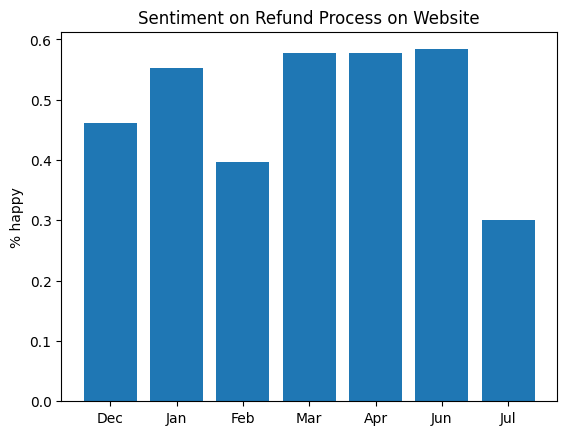

In [95]:
fig, ax = plt.subplots()

ax.bar(month, percent_happy)

ax.set_ylabel("% happy")
ax.set_title('Sentiment on Refund Process on Website')